<a href="https://colab.research.google.com/github/lcmolteberg/Machineoblig3/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3


In [1]:
!pip install pytorch-ignite

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import EarlyStopping
from copy import deepcopy
import torch.nn.functional as F
import torchvision.models as tvmodels
from sklearn.model_selection import StratifiedShuffleSplit


In [4]:
# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Exercise-1: Training Deep Neural Network on MNIST

In [5]:
# Dataset
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])
train_set = datasets.MNIST("./data", train=True, transform=tfm, download=True)
test_set = datasets.MNIST("./data", train=False, transform=tfm, download=True)

n_train = 1000
val_size = 200
train_size = n_train - val_size

# First 1000
y_first1000 = train_set.targets[:n_train].numpy()

# Stratified to keep classes balanced
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
train_idx, val_idx = next(sss.split(np.zeros(n_train), y_first1000))

# Subsets
train_subset = Subset(train_set, train_idx)
val_subset   = Subset(train_set, val_idx)

# Test set
test_subset  = Subset(test_set, np.arange(200))

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False)

In [6]:
# Model


# Builds network with layers
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )
        self._init_weights()

# Weights for layers
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Picture --> Vector
    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

model = DNN().to(device)


Epoch 01: Train 2.6163 | Val 0.7801
Epoch 02: Train 1.7907 | Val 0.5131
Epoch 03: Train 1.1984 | Val 0.4565
Epoch 04: Train 0.7926 | Val 0.4489
Epoch 05: Train 0.5197 | Val 0.4296
Epoch 06: Train 0.3389 | Val 0.4389
Epoch 07: Train 0.2201 | Val 0.4915
Epoch 08: Train 0.1430 | Val 0.4527
Epoch 09: Train 0.0938 | Val 0.4816


2025-11-05 02:36:59,387 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 10: Train 0.0622 | Val 0.4729
Restored best weights (val_loss=0.4296)


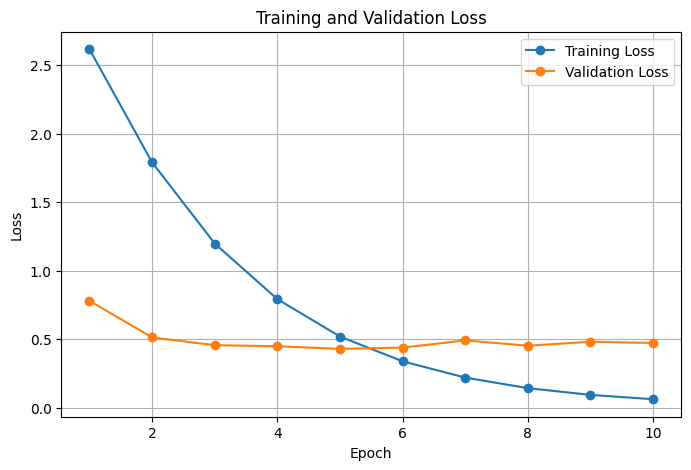

In [7]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

best_state = {"best_val": float("inf"), "weights": None}


trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

# --- enkel train-loss logging uten ekstra pass ---
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# Early stop
def score_function(engine):
    return -engine.state.metrics['loss']

early_stop = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Evaluates early stop each epoch
evaluator.add_event_handler(Events.COMPLETED, early_stop)

# Saving values for plot
train_losses, val_losses = [], []


@trainer.on(Events.EPOCH_COMPLETED)
def validate_and_log(engine):
    # Train loss from RunningAverage
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None

    # Validates, triggers early stop if condition met
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']

    # Appends loses for plotting
    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)

    # Saves best weights to
    if val_loss < best_state["best_val"]:
        best_state["best_val"] = val_loss
        best_state["weights"] = deepcopy(model.state_dict())

    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")


# Train
trainer.run(train_loader, max_epochs=50)
if best_state["weights"] is not None:
    model.load_state_dict(best_state["weights"])
    print(f"Restored best weights (val_loss={best_state['best_val']:.4f})")

# Plots losses
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()


## Q 1.1

In [8]:
# Run on test set
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")

Test set — loss: 0.3844, accuracy: 0.8650
Final Test Accuracy: 86.50%


# Exercise-2: Training Deep Neural Network on CIFAR-10


In [9]:
# Dataset

# CIFAR mean and std values
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)


tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])
train_set = datasets.CIFAR10("./data", train=True, transform=tfm, download=True)
test_set = datasets.CIFAR10("./data", train=False, transform=tfm, download=True)

n_train = 5000
val_size = 1000
train_size = n_train - val_size

# First 5000
y_first5000 = np.array(train_set.targets[:n_train])

# Stratified to keep classes balanced
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
train_idx, val_idx = next(sss.split(np.zeros(n_train), y_first5000))

# Subsets
train_subset = Subset(train_set, train_idx)
val_subset   = Subset(train_set, val_idx)

# Test set
test_subset  = Subset(test_set, np.arange(200))

# Batch sizes
batch_size = 128
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)


In [10]:
# Model

# Builds netowrk with layer config
class DNNCI(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(32*32*3, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 10)
        )
        self._init_weights()

# Weights for layers
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
# Picture --> Vector
    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

model = DNNCI().to(device)

Epoch 01: Train 3.8403 | Val 2.9506
Epoch 02: Train 2.8125 | Val 2.3353
Epoch 03: Train 2.0667 | Val 2.5056
Epoch 04: Train 1.5359 | Val 2.1725
Epoch 05: Train 1.1440 | Val 2.4010
Epoch 06: Train 0.8553 | Val 2.4238
Epoch 07: Train 0.6490 | Val 2.3779
Epoch 08: Train 0.4750 | Val 2.6711


2025-11-05 02:37:32,364 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 09: Train 0.3542 | Val 2.4196
Restored best weights (val_loss=2.1725)


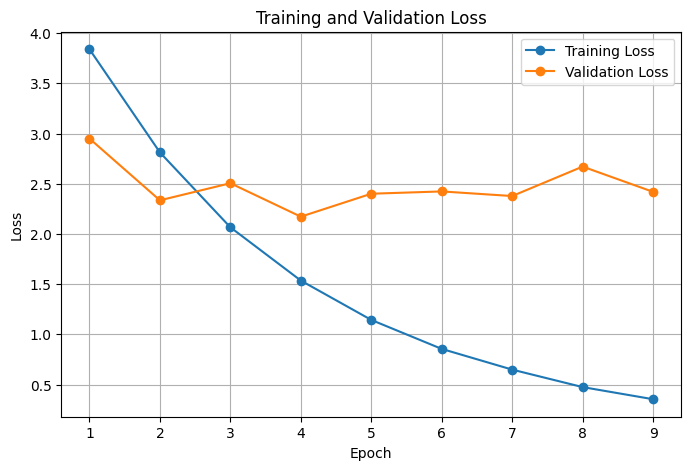

In [11]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

best_state = {"best_val": float("inf"), "weights": None}


trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

# Train loss logging
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# EArly stopping score, high is good
def score_function(engine):
    return -engine.state.metrics['loss']

early_stop = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Runs every epoch, so score gets checked
evaluator.add_event_handler(Events.COMPLETED, early_stop)

# loss history
train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def validate_and_log(engine):
    # Train loss from RunningAverage
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None

    # Validates
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']

    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)

    # Saving best wieghts
    if val_loss < best_state["best_val"]:
        best_state["best_val"] = val_loss
        best_state["weights"] = deepcopy(model.state_dict())

    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")


# train
trainer.run(train_loader, max_epochs=50)
if best_state["weights"] is not None:
    model.load_state_dict(best_state["weights"])
    print(f"Restored best weights (val_loss={best_state['best_val']:.4f})")

# Plot for val and train losses
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()


## Q 2.1

In [12]:

# Test set run
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")

Test set — loss: 2.1686, accuracy: 0.3650
Final Test Accuracy: 36.50%


# Exercise-3: Regularization with Alpha Dropout and MC Dropout

In [13]:
# Dataset
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307), std=(0.3081))
])

train_set = datasets.MNIST("./data", train=True, transform=tfm, download=True)
test_set = datasets.MNIST("./data", train=False, transform=tfm, download=True)


n_train = 1000
val_size = 200
train_size = n_train - val_size

# First 1000
y_first1000 = train_set.targets[:n_train].numpy()

# Stratified to keep classes balanced
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
train_idx, val_idx = next(sss.split(np.zeros(n_train), y_first1000))

# Subsets
train_subset = Subset(train_set, train_idx)
val_subset   = Subset(train_set, val_idx)

# Test set
test_subset  = Subset(test_set, np.arange(200))

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False)


In [14]:
# Model

# Builds model with layer config, same as 1 but dropout aswell
class DNN_ADMC(nn.Module):
  def __init__(self, p=0.1):
    super().__init__()
    self.flatten = nn.Flatten()
    self.net = nn.Sequential(
        nn.Linear(28*28, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 10)
    )
    self._lecun_init()

# LeCun weights
  def _lecun_init(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='linear')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

# Picture --> Vector
  def forward(self, x):
    return self.net(self.flatten(x))

model = DNN_ADMC().to(device)


Epoch 01: Train 2.4156 | Val 0.8021
Epoch 02: Train 1.8308 | Val 0.5765
Epoch 03: Train 1.3663 | Val 0.5222
Epoch 04: Train 1.0238 | Val 0.5541
Epoch 05: Train 0.7776 | Val 0.5032
Epoch 06: Train 0.6165 | Val 0.5024
Epoch 07: Train 0.4948 | Val 0.5713
Epoch 08: Train 0.3974 | Val 0.5801
Epoch 09: Train 0.3255 | Val 0.6092
Epoch 10: Train 0.2757 | Val 0.5871
Epoch 11: Train 0.2313 | Val 0.6490
Epoch 12: Train 0.1950 | Val 0.7400
Epoch 13: Train 0.1665 | Val 0.6986
Epoch 14: Train 0.1363 | Val 0.7979
Epoch 15: Train 0.1215 | Val 0.7257
Epoch 16: Train 0.1024 | Val 0.7323
Epoch 17: Train 0.1027 | Val 0.7328
Epoch 18: Train 0.0839 | Val 0.7667
Epoch 19: Train 0.0725 | Val 0.7545
Epoch 20: Train 0.0667 | Val 0.8030
Epoch 21: Train 0.0625 | Val 0.7823
Epoch 22: Train 0.0575 | Val 0.8611
Epoch 23: Train 0.0511 | Val 0.8072
Epoch 24: Train 0.0451 | Val 0.8254
Epoch 25: Train 0.0416 | Val 0.8492
Epoch 26: Train 0.0388 | Val 0.8828
Epoch 27: Train 0.0400 | Val 0.9239
Epoch 28: Train 0.0417 | Val

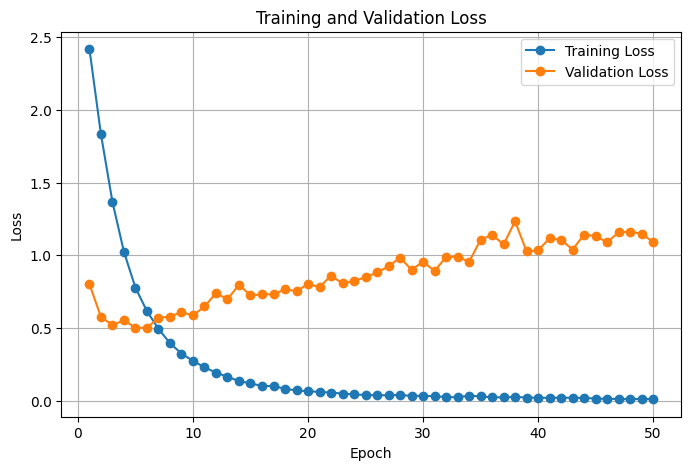

In [15]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Ignite engine handling one step per batch, forward -> loss -> backward -> Optimizer
trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)

# Ignite engine for inference and metrics over a dataloader
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# For plotting history
train_losses, val_losses = [], []

# Log after every finished spoch
@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(engine):
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)
    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")

trainer.run(train_loader, max_epochs=50)

# Plots losses
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()



## Q 3.1

In [16]:
# Test run
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")

Test set — loss: 0.5603, accuracy: 0.9200
Final Test Accuracy: 92.00%


## Q 3.2

In [17]:
# MonteCarlo-dropout

def mc_dropout(model, loader, device, T=20):
    was_training = model.training
    model.train()

    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        B = x.size(0)
        x_rep = x.unsqueeze(0).expand(T, -1, -1, -1, -1).reshape(T*B, *x.shape[1:])
        logits = model(x_rep)
        probs = F.softmax(logits, dim=1).view(T, B, -1).mean(0)
        pred = probs.argmax(1)

        correct += (pred == y).sum().item()
        total += B
    if not was_training:
        model.eval()
    return correct / total

base_acc = m['accuracy']
mc_acc   = mc_dropout(model, test_loader, device, T=20)
print(f"Test (no MC): {base_acc*100:.2f}%")
print(f"MC-Dropout (T=20): {mc_acc*100:.2f}%")



Test (no MC): 92.00%
MC-Dropout (T=20): 92.00%


# Exercise-4: Transfer Learning with Pre-trained CNN

In [18]:
# Dataset

# CIFAR mean and std values
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

# Transformationpipeline for CIFAR10
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

# Downloads correct dataset
train_set = datasets.CIFAR10("./data", train=True, transform=tfm, download=True)
test_set = datasets.CIFAR10("./data", train=False, transform=tfm, download=True)

# Correct split
n_train = 2000
val_size = 400
train_size = n_train - val_size

labels = np.array(train_set.targets[:n_train])

# Stratified to keep classes balanced
splitter = StratifiedShuffleSplit(n_splits=1, test_size = val_size, random_state=seed)
train_idx, val_idx = next(splitter.split(np.zeros(len(labels)), labels))

# Creates subset
train_subset = Subset(train_set, train_idx)
val_subset = Subset(train_set, val_idx)
test_subset = Subset(test_set, np.arange(500))

# Sets up batches
batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)

In [19]:
# Model

# Pretrained from torchvision
base_model = tvmodels.mobilenet_v2(weights=tvmodels.MobileNet_V2_Weights.IMAGENET1K_V2)
for p in base_model.features.parameters():
  p.requires_grad = False

# Freezes layers of pretrained
base_model.features.eval()
for m in base_model.features.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

# Layers for feature extraction
base_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)
)
model = base_model.to(device)



Epoch 01 | train 2.2064 | val 1.9573
Epoch 02 | train 2.0313 | val 1.8840
Epoch 03 | train 1.9224 | val 1.8737
Epoch 04 | train 1.8233 | val 1.8287
Epoch 05 | train 1.7955 | val 1.8268


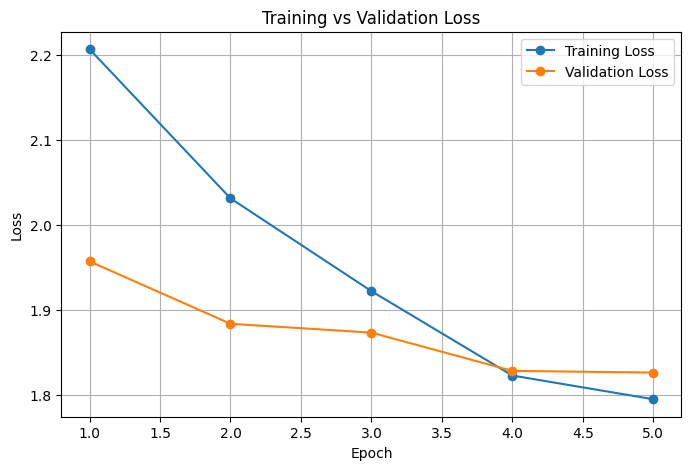

In [20]:
# Optimizer

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# --- Trainer & Evaluators ---
# Ignite engine handling one step per batch
trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)

# Valuate Ignite Engine for infernece
evaluator  = create_supervised_evaluator(
    model,
    metrics={"accuracy": Accuracy(), "loss": Loss(loss_fn)},
    device=device
)


# Track training loss
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss_batch")

# For loss plotting
train_losses, val_losses = [], []


@trainer.on(Events.EPOCH_COMPLETED)
def log_and_validate(engine):
    # Batch average
    train_loss = engine.state.metrics["train_loss_batch"]
    # Validating set
    evaluator.run(val_loader)
    m = evaluator.state.metrics
    val_loss = m["loss"]
    train_losses.append(float(train_loss))
    val_losses.append(float(val_loss))
    print(f"Epoch {engine.state.epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")


# Training
max_epochs = 5
trainer.run(train_loader, max_epochs=max_epochs)

# --- Plot ---
plt.figure(figsize=(8,5))
ep = range(1, len(train_losses)+1)
plt.plot(ep, train_losses, marker='o', label='Training Loss')
plt.plot(ep, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss')
plt.grid(True); plt.legend(); plt.show()


## Q 4.1

In [21]:
# Test run
evaluator.run(test_loader)
tm = evaluator.state.metrics
print(f"Test loss: {tm['loss']:.4f} | Test accuracy: {tm['accuracy']*100:.2f}%")

Test loss: 1.8889 | Test accuracy: 33.40%


# Exercise-5: Deeper CNN Training on SVHN

In [22]:
# Dataset

svhn_mean = [0.4377, 0.4438, 0.4728]
svhn_std = [0.1980, 0.2010, 0.1970]

# Transformationpipeline
tfm = transforms.Compose([
    transforms.ToTensor(),  # 0-1
    transforms.Normalize(mean=svhn_mean, std=svhn_std)
])

# Changes 10 --> 0
target_map = lambda y: 0 if int(y) == 10 else int(y)

# Gets dataset
train_set = datasets.SVHN("./data", split="train", transform=tfm,
                          target_transform=target_map, download=True)
test_set  = datasets.SVHN("./data", split="test", transform=tfm,
                          target_transform=target_map, download=True)
# Sets corrent amount
n_train = 2000
val_size = 400
n_test = 500
train_size = n_train - val_size

# Gets first 2K from train set
y_first2000 = np.array(train_set.labels[:n_train])
y_first2000 = np.array([target_map(int(y)) for y in y_first2000])

# Splits into train and val set
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
train_idx, val_idx = next(sss.split(np.zeros(n_train), y_first2000))

# Build subsets for train and val
train_subset = Subset(train_set, train_idx)
val_subset   = Subset(train_set, val_idx)

# Gets 500 first test images
test_idx  = np.arange(0, n_test)
test_subset = Subset(test_set, test_idx)

# Sets up batches
batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size, shuffle=False)


In [23]:
# Model

# Builds network with layer config
class SVHN_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

# Feature map and mroe
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*8*8, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 10)
    )

# Picture --> Outputs
  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

model = SVHN_CNN().to(device)



Epoch 01 | train 2.2624 | val 2.2270
Epoch 02 | train 2.2417 | val 2.2065
Epoch 03 | train 2.0940 | val 1.7282
Epoch 04 | train 1.6435 | val 1.2148
Epoch 05 | train 1.2618 | val 0.9975
Epoch 06 | train 0.9489 | val 0.9908
Epoch 07 | train 0.7373 | val 0.9274
Epoch 08 | train 0.5745 | val 0.8748
Epoch 09 | train 0.4413 | val 0.8177
Epoch 10 | train 0.3371 | val 0.9881
Epoch 11 | train 0.2610 | val 0.9875
Epoch 12 | train 0.1991 | val 1.0522
Epoch 13 | train 0.1690 | val 1.0470
Epoch 14 | train 0.1618 | val 1.1373
Epoch 15 | train 0.1596 | val 1.1053


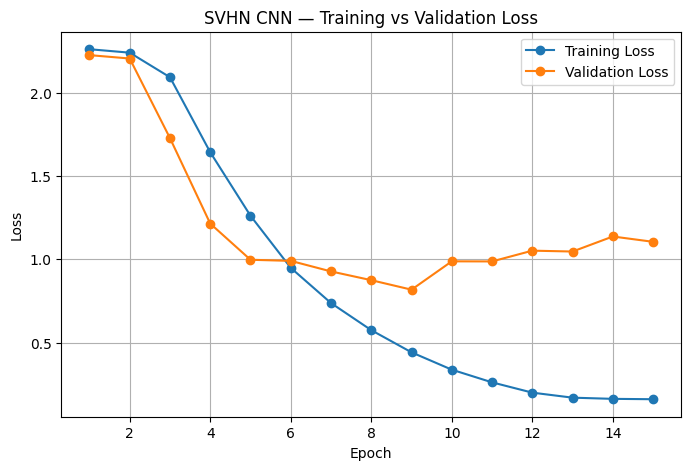

In [24]:
# Optimizer

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Ignite trainer for handling trainingloop
trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)

# Ignite evaluator, does model.eval() / no_grad and calculates metrics over a dataloader
evaluator = create_supervised_evaluator(
    model, metrics={"loss": Loss(loss_fn), "accuracy": Accuracy()}, device=device
)

# Training loss batch average
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss_batch")

#Plotting history
train_losses, val_losses = [], []

# Reads training and val loss, validates metrics on val_loader
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_validate(engine):
    train_loss = engine.state.metrics["train_loss_batch"]
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics["loss"]
    train_losses.append(float(train_loss))
    val_losses.append(float(val_loss))
    print(f"Epoch {engine.state.epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")

max_epochs = 15
trainer.run(train_loader, max_epochs=max_epochs)

# Plots train and val loss
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('SVHN CNN — Training vs Validation Loss')
plt.grid(True); plt.legend(); plt.show()

## Q 5.1

In [25]:
evaluator.run(test_loader)
test_metrics = evaluator.state.metrics
print(f"\nTest loss: {test_metrics['loss']:.4f} | Test accuracy: {test_metrics['accuracy']*100:.2f}%")


Test loss: 1.4081 | Test accuracy: 71.40%


# Exercise-6: CNN with SGD, MC Dropout, and Epistemic Uncertainty

In [26]:
# Dataset

svhn_mean = [0.4377, 0.4438, 0.4728]
svhn_std = [0.1980, 0.2010, 0.1970]

# Transformationspipeline
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=svhn_mean, std=svhn_std)
])
target_map = lambda y: 0 if int(y) == 10 else int(y)

train_set = datasets.SVHN("./data", split='train', transform=tfm, target_transform=target_map, download=True)
test_set = datasets.SVHN("./data", split='test', transform=tfm, target_transform=target_map, download=True)

n_train_total = 2000
val_size = 400  # 1600 train / 400 val

# Labels for first 2K images
y_first2000 = np.array(train_set.labels[:n_train_total])
y_first2000 = np.array([target_map(int(y)) for y in y_first2000])  # 0..9

# Splits into train and val
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
train_idx, val_idx = next(sss.split(np.zeros(n_train_total), y_first2000))

# Builds subset
train_subset = Subset(train_set, train_idx)
val_subset   = Subset(train_set, val_idx)

# Gets 500 first test images
n_test = 500
test_idx  = np.arange(0, n_test)
test_subset = Subset(test_set, test_idx)

# Builds batches
batch = 32
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)
val_loader   = DataLoader(val_subset,   batch_size=batch,   shuffle=False)
test_loader  = DataLoader(test_subset,  batch_size=batch,   shuffle=False)


In [27]:
# Model

# Builds network from layer config
class SVHN_SGD_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
# Feature map and mroe
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)
        )

# Picture --> Outputs
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SVHN_SGD_CNN().to(device)

Epoch 01 | train 2.2718 | val 2.2526
Epoch 02 | train 2.2425 | val 2.2211
Epoch 03 | train 2.2030 | val 2.2051
Epoch 04 | train 2.1366 | val 2.0297
Epoch 05 | train 1.9560 | val 1.7719
Epoch 06 | train 1.6665 | val 1.5003
Epoch 07 | train 1.4074 | val 1.2467
Epoch 08 | train 1.1392 | val 1.1359
Epoch 09 | train 0.9298 | val 0.9933
Epoch 10 | train 0.7739 | val 0.9485
Epoch 11 | train 0.6423 | val 1.0020
Epoch 12 | train 0.5262 | val 0.9675
Epoch 13 | train 0.4525 | val 0.9965
Epoch 14 | train 0.3781 | val 1.0438
Epoch 15 | train 0.3031 | val 1.0256


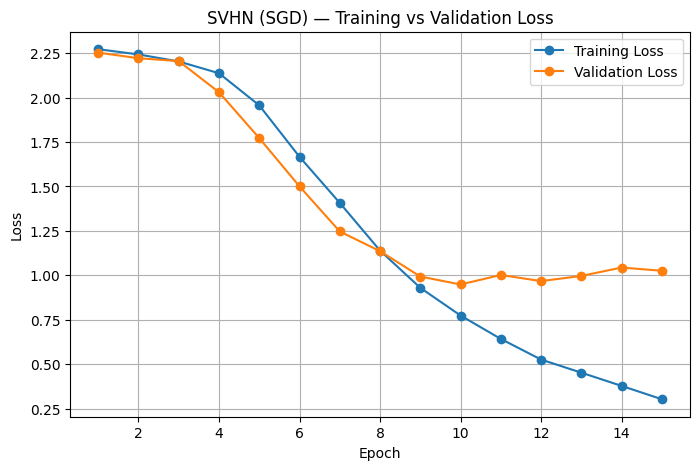

In [28]:
# Optimizer

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

# # Ignite trainer for handling trainingloop
trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)

# Ignite evaluator, does model.eval() / no_grad and calculates metrics over a dataloader
evaluator = create_supervised_evaluator(
    model, metrics={"loss": Loss(loss_fn), "accuracy": Accuracy()}, device=device
)

# # Training loss batch average
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss_batch")

#Plotting history
train_losses, val_losses = [], []

# Reads training and val loss, validates metrics on val_loader
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_validate(engine):
    # Hent snitt-train-loss for epoken
    train_loss = float(engine.state.metrics["train_loss_batch"])
    # Kjør validering på hele val_loader
    evaluator.run(val_loader)
    m = evaluator.state.metrics
    val_loss = float(m["loss"])
    # Logg/lagre
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {engine.state.epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")


# Runs trainer
max_epochs = 15
trainer.run(train_loader, max_epochs=max_epochs)

# Plots train and val loss
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('SVHN (SGD) — Training vs Validation Loss')
plt.grid(True); plt.legend(); plt.show()

## Q 6.1

In [29]:
# Test run
evaluator.run(test_loader)
tm = evaluator.state.metrics
print(f"\nTest loss: {tm['loss']:.4f} | Test accuracy: {tm['accuracy']*100:.2f}%")



Test loss: 1.2223 | Test accuracy: 72.20%


## Q 6.2

In [35]:
# Dropout during eval
def _enable_dropout_only(model: nn.Module):
    """Keep model in eval, but turn ON only Dropout layers (BN etc. stay in eval)."""
    model.eval()
    for m in model.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout1d, nn.Dropout2d, nn.Dropout3d)):
            m.train()

@torch.inference_mode()
def mc_dropout_eval(model, loader, T=20, device=None):
    """
    MC Dropout:
      - Dropout active at inference
      - Average probs over T passes
      - Epistemic uncertainty = variance across passes (per class)
    Returns:
      mc_acc (float), epistemic_per_sample (N,), mean_probs (N,C), var_probs (N,C)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    _enable_dropout_only(model)

    mean_list, var_list, y_list = [], [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        # T stochastic passes with dropout ON
        probs_T = torch.stack([torch.softmax(model(xb), dim=1) for _ in range(T)])  # [T,B,C]
        mean_p  = probs_T.mean(0)                           # [B,C]
        var_p   = probs_T.var(0, unbiased=False)            # [B,C]

        mean_list.append(mean_p.cpu())
        var_list.append(var_p.cpu())
        y_list.append(yb.cpu())

    mean_probs = torch.cat(mean_list)   # [N,C]
    var_probs  = torch.cat(var_list)    # [N,C]
    targets    = torch.cat(y_list)      # [N]

    preds  = mean_probs.argmax(1)
    mc_acc = (preds == targets).float().mean().item()

    # Per-sample scalar epistemic uncertainty = mean variance over classes
    epistemic_per_sample = var_probs.mean(1).numpy()

    return mc_acc, epistemic_per_sample, mean_probs.numpy(), var_probs.numpy()

# Run MC Dropout on test set (T=20)
T = 20
mc_acc, epistemic_per_sample, mean_probs, var_probs = mc_dropout_eval(model, test_loader, T=T, device=device)
print(f"Q6.2 — MC Dropout (T={T}) accuracy: {mc_acc*100:.2f}%")

Q6.2 — MC Dropout (T=20) accuracy: 72.20%


## Q 6.3

In [36]:
avg_epi = float(np.mean(epistemic_per_sample))
print(f"Average epistemic uncertainty (mean predictive variance): {avg_epi:.3f}")

Average epistemic uncertainty (mean predictive variance): 0.007
